<h1>Data Import and Path Setup</h2>

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from openTSNE import TSNE
import umap

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn import mixture

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

from time import time
import seaborn as sns


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
umap_seed = 143
tsne_seed = 42
max_jobs = -1    # If the RAM gets used up in your case, modify it to reduce RAM usage
num_comp = 2
num_clusters = 2
# Dataset extraction and analysis
path_expression = '../data/TCGA.BRCA.expression.txt'
path_metadata = '../data/TCGA.BRCA.metadata.txt'
path_mutation = '../data/TCGA.BRCA.mutations.txt'

df_exp = pd.read_csv(path_expression, delimiter='\t')  # \s+ handles multiple spaces
df_meta = pd.read_csv(path_metadata, delimiter='\t')
df_mut = pd.read_csv(path_mutation, delimiter=r'\t')
df_exp.head()


/tmp/ipykernel_8805/2362280137.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_mut = pd.read_csv(path_mutation, delimiter=r'\t')


,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,0.0000,16.3644,12.9316,52.1503,408.076,0.0,1187.010,0.0000,...,415.824,931.957,129.5920,1007.780,1658.500,258.4940,1208.370,3507.25,1894.930,1180.460
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.0000,9.2659,17.3790,69.7553,563.893,0.0,516.041,1.0875,...,1161.330,965.198,59.8151,448.613,1343.120,198.4770,603.589,5504.62,1318.650,406.743
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.9066,11.6228,9.2294,154.2970,1360.830,0.0,592.022,0.0000,...,305.422,2531.280,35.3581,533.998,768.812,331.8220,532.185,5458.75,942.883,509.519
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.0000,12.0894,11.0799,143.8640,865.536,0.0,552.751,0.4137,...,394.506,668.597,55.0269,437.733,863.881,175.4240,607.365,5691.35,781.134,700.869
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.0000,6.8468,14.4298,84.2128,766.383,0.0,260.851,0.4255,...,405.711,674.468,48.9362,424.255,1049.790,14.0426,775.745,4041.70,831.915,881.702


In [3]:
df_meta.head()


,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-3C-AAAU,BRCA,55.0,FEMALE,WHITE,Stage X,Infiltrating Lobular Carcinoma,[Not Available],WITH TUMOR,Alive,0.0,4047.0,0.0,4047.0,1.0,1808.0,1.0,1808.0,NaN
1,TCGA-3C-AALI,BRCA,50.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,4005.0,0.0,4005.0,0.0,4005.0,0.0,4005.0,NaN
2,TCGA-3C-AALJ,BRCA,62.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1474.0,0.0,1474.0,0.0,1474.0,0.0,1474.0,NaN
3,TCGA-3C-AALK,BRCA,52.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IA,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1448.0,0.0,1448.0,NaN,NaN,0.0,1448.0,NaN
4,TCGA-4H-AAAK,BRCA,50.0,FEMALE,WHITE,Stage IIIA,Infiltrating Lobular Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,348.0,0.0,348.0,0.0,348.0,0.0,348.0,NaN


In [4]:
df_mut.head()


,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,SIFT,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS
0,TCGA-3C-AAAU,WDR11,0,.,GRCh37,10,122668955,122668955,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,TATGAGATGTA,5
1,TCGA-3C-AAAU,GATA3,0,.,GRCh37,10,8115874,8115875,+,Frame_Shift_Ins,...,.,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR10071:...",HIGH,insertion,PASS,NONE,INDELOCATOR*|VARSCANI*|PINDEL,CATCTCGCCCT,3
2,TCGA-3C-AAAU,MALAT1,0,.,GRCh37,11,65272906,65272908,+,RNA,...,.,.,.,MODIFIER,deletion,PASS,NONE,VARSCANI*|PINDEL,AATAATAAAGCCCA,2
3,TCGA-3C-AAAU,CD248,0,.,GRCh37,11,66082467,66082467,+,Missense_Mutation,...,tolerated(0.12),benign(0.001),"Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...",MODERATE,SNV,PASS,NONE,MUTECT|VARSCANS,GTGCTCGGCAA,2
4,TCGA-3C-AAAU,NPAS4,0,.,GRCh37,11,66193652,66193652,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,ATCAAGAGACT,4


<h1>Data Visualization</h1>

In [42]:
df_logexp = pd.concat([df_exp.iloc[:,:2], np.log2(df_exp.iloc[:,2:]+1)], axis=1)
df_logexp.head()

,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,0.000000,4.118061,3.800289,5.732006,8.676225,0.0,10.214331,0.000000,...,8.703295,9.865667,7.028923,9.978396,10.696533,8.019557,10.240040,11.776536,10.888690,10.206355
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.000000,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,...,10.182804,9.916175,5.926358,8.812540,10.392446,7.640079,9.239811,12.426689,10.365940,8.671516
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.931002,3.657960,3.354650,7.278886,10.411331,0.0,9.211942,0.000000,...,8.259376,11.306221,5.184205,9.063390,9.588362,8.378607,9.058492,12.414619,9.882464,8.995821
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.000000,3.710327,3.594537,7.178555,9.759116,0.0,9.113094,0.499476,...,8.627556,9.387149,5.808048,8.777199,9.756358,7.462903,9.248793,12.474809,9.611272,9.455058
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.000000,2.972104,3.947647,6.412998,9.583803,0.0,8.032602,0.511468,...,8.667860,9.399744,5.642014,8.732184,10.037259,3.910982,9.601297,11.981103,9.702025,9.785783


Text(0.5, 1.0, 'distribution of mean expression values')

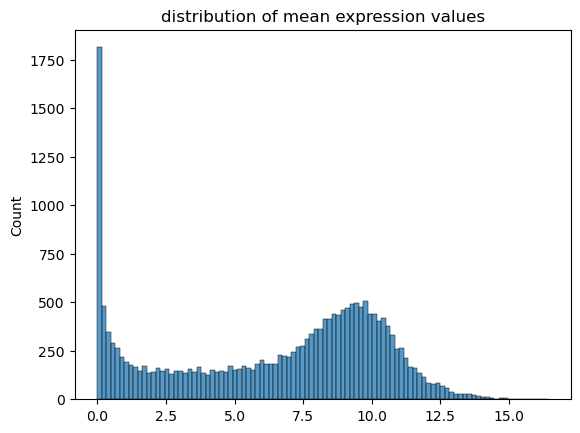

In [48]:
ax = sns.histplot(df_logexp.iloc[:,2:].mean(axis=0), bins=100)
ax.set_title('distribution of mean expression values')

<h2>Filter genes by mean and variance</h2>

Will use a threshold of 1.5 to keep 16557 genes


Text(0.5, 1.0, 'Log2 Gene Variance Distribution')

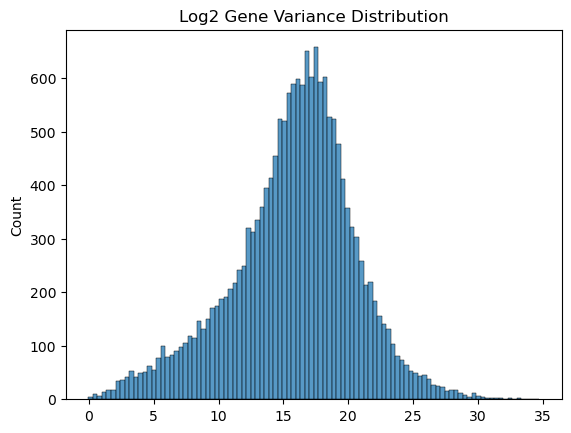

: 

In [ ]:
threshold = 1.5
keep_count = (df_logexp.iloc[:,2:].mean(axis=0) >= threshold).sum()
print(f'Will use a threshold of {threshold} to keep {keep_count} genes')

# remove low expressed genes
df_logexp_filtered = df_exp.iloc[:,2:].loc[:, df_exp.iloc[:, 2:].mean(axis=0) >= 1]
df_logexp_filtered = df_logexp_filtered.loc[:, df_logexp_filtered.median(axis=0) > 0]

gene_variance = df_logexp_filtered.iloc[:,2:].var(axis=0)
ax = sns.histplot(np.log2(gene_variance), bins=100)
plt.title("Log2 Gene Variance Distribution")

# keep some percentile of genes with high variance. For PCA just remove bottom 10 or 25%
var_thresh = gene_variance.quantile(0.1)
highvar_genes = gene_variance[gene_variance >= var_thresh].index
df_highvar = df_logexp_filtered[highvar_genes]


<h1>Data Summary</h1>

In [17]:
summary = df_exp.describe()
print(summary)

       ?|100130426  ?|100133144  ?|100134869      ?|10357      ?|10431  \
count  1132.000000  1132.000000  1132.000000  1132.000000  1132.000000   
mean      0.011753     8.669699     7.501182   111.920835  1064.702094   
std       0.101698     7.675153     5.664275    59.303863   464.503935   
min       0.000000     0.000000     0.000000    28.934500   345.121000   
25%       0.000000     3.365750     3.782925    79.381750   769.207750   
50%       0.000000     7.121900     6.078550    99.451250   966.939500   
75%       0.000000    12.196575     9.727250   128.866750  1232.515000   
max       2.020300    91.827500    40.253600  1119.190000  5009.510000   

       ?|136542     ?|155060      ?|26823     ?|280660     ?|317712  ...  \
count    1132.0  1132.000000  1132.000000  1132.000000  1132.000000  ...   
mean        0.0   221.380959     0.512916     0.134520     0.024898  ...   
std         0.0   179.396452     0.631361     2.078594     0.550541  ...   
min         0.0    18.731400 

In [18]:
min(summary.loc['min',:])

0.0

In [19]:
df_exp_transposed = df_exp.T

df_exp_transposed.columns = df_exp_transposed.loc['sample_id']

df_exp_transposed = df_exp_transposed.drop(['sample_id'], axis=0)

df_exp_transposed = df_exp_transposed.drop(['patient_id'], axis=0)

df_exp_transposed = df_exp_transposed.astype(float)

df_exp_transposed.head()

sample_id,TCGA-3C-AAAU-01A-11R-A41B-07,TCGA-3C-AALI-01A-11R-A41B-07,TCGA-3C-AALJ-01A-31R-A41B-07,TCGA-3C-AALK-01A-11R-A41B-07,TCGA-4H-AAAK-01A-12R-A41B-07,TCGA-5L-AAT0-01A-12R-A41B-07,TCGA-5L-AAT1-01A-12R-A41B-07,TCGA-5T-A9QA-01A-11R-A41B-07,TCGA-A1-A0SB-01A-11R-A144-07,TCGA-A1-A0SD-01A-11R-A115-07,...,TCGA-UL-AAZ6-01A-11R-A41B-07,TCGA-UU-A93S-01A-21R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-W8-A86G-01A-21R-A36F-07,TCGA-WT-AB41-01A-11R-A41B-07,TCGA-WT-AB44-01A-11R-A41B-07,TCGA-XX-A899-01A-11R-A36F-07,TCGA-XX-A89A-01A-11R-A36F-07,TCGA-Z7-A8R5-01A-42R-A41B-07,TCGA-Z7-A8R6-01A-11R-A41B-07
?|100130426,0.0000,0.0000,0.9066,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
?|100133144,16.3644,9.2659,11.6228,12.0894,6.8468,3.9889,0.0000,1.4644,15.3396,9.5178,...,0.3992,4.3126,0.0000,5.5624,0.0000,0.0000,14.3858,22.3240,2.2638,6.8865
?|100134869,12.9316,17.3790,9.2294,11.0799,14.4298,13.6090,10.5949,8.9958,14.3935,11.3241,...,14.3720,10.8828,3.0792,14.3711,6.3091,3.2580,21.4409,27.2744,7.2933,24.7795
?|10357,52.1503,69.7553,154.2970,143.8640,84.2128,114.2570,115.9980,107.5630,116.3870,60.2630,...,135.6240,136.1290,29.9974,128.3150,53.6278,42.2643,137.7760,64.1427,85.0461,167.5510
?|10431,408.0760,563.8930,1360.8300,865.5360,766.3830,807.7430,1108.3900,1420.5000,657.2810,977.9180,...,1570.1400,2886.4000,1721.8800,697.6740,1245.2700,1877.4200,652.7560,722.7210,1140.2800,1003.5700


In [20]:
exp_tranposed_summary = df_exp_transposed.describe()
print(exp_tranposed_summary)

sample_id  TCGA-3C-AAAU-01A-11R-A41B-07  TCGA-3C-AALI-01A-11R-A41B-07  \
count                      20531.000000                  20531.000000   
mean                         878.406577                    933.033961   
std                         2749.973106                   3615.040606   
min                            0.000000                      0.000000   
25%                            4.825200                      7.612800   
50%                          206.795000                    204.274000   
75%                          846.309500                    846.656000   
max                       138975.000000                 194625.000000   

sample_id  TCGA-3C-AALJ-01A-31R-A41B-07  TCGA-3C-AALK-01A-11R-A41B-07  \
count                      20531.000000                  20531.000000   
mean                         906.240095                    982.764200   
std                         3240.290710                   4982.341397   
min                            0.000000           

In [21]:
df_exp_log = df_exp.copy()

In [22]:
df_exp_log = np.log2(df_exp_transposed + 1)
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_exp_log), 
                         index=df_exp_log.index, columns=df_exp_log.columns)

In [ ]:
# Sample 100,000 values from the flattened matrix
flat_sample = np.random.choice(df_exp.iloc[:,2:].values.flatten(), size=100_000, replace=False)

sns.histplot(flat_sample, bins=100, kde=True)
plt.title("Distribution of Sampled Expression Values")
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.show()


In [ ]:
df_exp.head()

In [ ]:
df_exp.iloc[:30, :].boxplot(rot=90, figsize=(15, 5))
plt.title("Gene Expression Distribution (First 30 Samples)")
plt.ylabel("Expression Level")
plt.show()